# Inicialização do ambiente

In [1]:
# Essentials
import pandas as pd
import numpy as np

import datetime as dt
import gc
import math
import warnings, time
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy import stats

# Estebelece limites para visualização no notebook
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',500)

# Limita a 3 casas decimais a apresentação das variaveis tipo float
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

# Funções recorrentes

In [2]:
# Apresenta 3 tipos de gráficos para cada variável - Scatter, Histograma e Boxplot
def graficos(df, var1, var2):

    # cria espaço para 3 gráficos em cada linha 
    f, axes = plt.subplots(nrows=1, ncols=3)
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    # Gráfico 1 - Scatter plot comparando variável com target 
    axes[0].scatter(x = df[var2], y = df[var1], alpha=0.8)
    axes[0].set_title(var2 + ' x ' + var1)

    # Gráfico 2 - Histograma 
    df[var2].hist(bins = 30, ax = axes[1])
    axes[1].set_title('Distribution of ' + var2, fontsize=12)
    
    # Gráfico 3 - Boxplot 
    df.boxplot(column = var2, ax = axes[2],fontsize=12)
    
    plt.show()

# FASE 1 - Preparação de datasets de Instrumentos e Medições


**Faz o tratamento dos dados dos 2 datasets e cria nova tabela para uso nos estudos**


## Etapa 1.1 - Dados de Instrumentos

**Realiza carga da tabela de instrumentos**

São utilizadas somente as variáveis de identificação do instrumento e valor de cota. Os dados de cota serão adotados nos casos em que não houver indicação de valores nas medições.

### Carga e tratamento básico dos dados

In [3]:
cols = ['cod_inst', 'tipo_inst', 'cota_fundo']
df_inst = pd.read_csv('instrumentos.csv', sep=';', encoding='latin1', decimal=',', usecols=cols)

In [4]:
# Preenche campos vazios na variavel cota_fundo
df_inst['cota_fundo'] = df_inst['cota_fundo'].fillna(0)

In [5]:
# Ordena registros por código de instrumento
df_inst = df_inst.sort_values(['cod_inst'])
df_inst.head()

,tipo_inst,cod_inst,cota_fundo
0,medidor de nivel de agua,nvl_agua_01,925.762
1,medidor de nivel de agua,nvl_agua_02,918.023
2,medidor de nivel de agua,nvl_agua_03,938.437
3,medidor de nivel de agua,nvl_agua_04,926.793
4,medidor de nivel de agua,nvl_agua_05,918.652


## Etapa 1.2 - Dados de Medições

**Realiza carga da tabela com informações sobre as medições dos instrumentos ao longo do tempo.**

Em análise prévia, foram identificadas variáveis essenciais à análise e somente essas são carregadas.

Também são realizados filtros para eliminação de registros sem utilidade (sem dados) e preenchimento de campos sem valores de medição com os dados oriundos da tabela de instrumentos tratada anteriormente.

### Carga e tratamento básico dos dados

Faz a carga somente das variáveis que interessam na análise. 

In [6]:
cols = ['num_os', 'cod_inst', 'tipo_inst', 'situacao', 'condicao', 'data_med', 'valor', 'unidade']
df_med = pd.read_csv('medicoes.csv', sep=';', encoding='latin1', decimal=',', usecols=cols)

In [7]:
print('Dimensões de df_med:', df_med.shape)
df_med.head()

Dimensões de df_med: (5801, 8)


,num_os,cod_inst,tipo_inst,situacao,condicao,data_med,valor,unidade
0,419.000,vazao_01,medidor de vazao,Realizada,NaN,02/02/2009 10:00,0.465,LPS
1,419.000,vazao_02,medidor de vazao,Realizada,NaN,02/02/2009 10:00,3.448,LPS
2,419.000,vazao_03,medidor de vazao,Realizada,NaN,02/02/2009 10:00,1.373,LPS
3,457.000,vazao_01,medidor de vazao,Realizada,NaN,02/07/2008 09:00,1.267,LPS
4,457.000,vazao_02,medidor de vazao,Realizada,NaN,02/07/2008 09:00,0.464,LPS


In [8]:
df_med.dtypes

num_os       float64
cod_inst      object
tipo_inst     object
situacao      object
condicao      object
data_med      object
valor        float64
unidade       object
dtype: object

In [9]:
# Variável data_med foi carregada como string e com informações de data e hora.
# Remove informação de hh:mm, converte para datetime e ajusta formato para aaaa-mm-dd
df_med['data_med'] = df_med['data_med'].str.split(' ').str[0] 
df_med['data_med'] = pd.to_datetime(df_med['data_med'], format="%d/%m/%Y")
df_med.head(3)

,num_os,cod_inst,tipo_inst,situacao,condicao,data_med,valor,unidade
0,419.000,vazao_01,medidor de vazao,Realizada,NaN,2009-02-02,0.465,LPS
1,419.000,vazao_02,medidor de vazao,Realizada,NaN,2009-02-02,3.448,LPS
2,419.000,vazao_03,medidor de vazao,Realizada,NaN,2009-02-02,1.373,LPS


In [10]:
# Removendo registros com variável 'situacao'= 'Não realizadas'. Não possuem dados para avaliar.
df_med.drop(df_med[df_med['situacao'] == 'Não Realizada'].index, axis = 0, inplace=True)

# Uma vez que situação agora só possui um status, não contribui mais para a análise 
df_med.drop(['situacao'], axis=1, inplace=True)

In [11]:
# Preenchendo campo 'unidade' com tipo de medida de acordo com tipo_inst
# Piezometros, Medidor de Nivel de Água e Régua do Reservatório = m
# Medidor de vazão = LPS
for i in range(0, len(df_med)):
    if df_med.iloc[i, 2] == 'piezometro':
        df_med.iloc[i, 6] = 'm'
    elif df_med.iloc[i, 2] == 'medidor de nivel de agua':
        df_med.iloc[i, 6] = 'm'
    elif df_med.iloc[i, 2] == 'regua do reservatorio':
        df_med.iloc[i, 6] = 'm'
    else: 
        df_med.iloc[i, 6] = 'LPS'

# Apresentação para verificação
df_med.groupby(['tipo_inst', 'unidade'])['unidade'].count()

tipo_inst                 unidade
medidor de nivel de agua  m           703
medidor de vazao          LPS         341
piezometro                m          3607
regua do reservatorio     m           465
Name: unidade, dtype: int64

In [12]:
# Remove registros com OS em branco
df_med.drop(df_med[df_med['num_os'].isna()].index, axis=0, inplace=True)

# Completa campos faltantes
df_med['valor'] = df_med['valor'].fillna(0)
df_med['condicao'] = df_med['condicao'].fillna('Nao')

In [13]:
print(df_med.dtypes)
print()
print(df_med.isnull().sum())
df_med.head(3)

num_os              float64
cod_inst             object
tipo_inst            object
condicao             object
data_med     datetime64[ns]
valor               float64
unidade              object
dtype: object

num_os       0
cod_inst     0
tipo_inst    0
condicao     0
data_med     0
valor        0
unidade      0
dtype: int64


,num_os,cod_inst,tipo_inst,condicao,data_med,valor,unidade
0,419.000,vazao_01,medidor de vazao,Nao,2009-02-02,0.465,LPS
1,419.000,vazao_02,medidor de vazao,Nao,2009-02-02,3.448,LPS
2,419.000,vazao_03,medidor de vazao,Nao,2009-02-02,1.373,LPS


In [14]:
# Remove registros de OS que só possuem medições da regua
# Mesmo essa sendo a variável target, sozinha e sem outros instrumentos para comparação, ela não agrega conteúdo

# Obtem lista de números de OS
num_os = df_med['num_os'].unique()

# Cria loop para leitura e validação. 
# Se OS só contem 1 registro (Régua do Reservatório), então é removida
# Se OS não contém registro relativo à Régua do Reservatório também é removida
for os in num_os:
    df = df_med[df_med['num_os'] == os]
    if (len(df) == 1) or (len(df[df['tipo_inst']=='regua do reservatorio'].index.values) == 0):
        df_med.drop(df_med[df_med['num_os'] == os].index, axis=0, inplace=True)

In [15]:
# Usa dataset de instrumentos para preencher campos vazios com dados de referencia
for i in range(0,len(df_med)):
    if (df_med.iloc[i, 3] == 'SECO') & (df_med.iloc[i, 5] == 0):
        inst = df_med.iloc[i, 1]
        cota = 0
        for j in range(0, len(df_inst)):
            if df_inst.iloc[j, 0] == inst:
                cota = df_inst.iloc[j, 1]
        df_med.iloc[i, 5] = cota       

In [16]:
# Verifica se existe algum registro sem informação
df_med.isnull().sum()

num_os       0
cod_inst     0
tipo_inst    0
condicao     0
data_med     0
valor        0
unidade      0
dtype: int64

In [17]:
# Análise visual rápida para entender se medições
# dentro de cada OS são executadas no mesmo dia
# Durante o processo foram apresentados todos os registros,
# mas para essa documentação limitei somente aos 10 primeiros#
pd.DataFrame(df_med.groupby(['num_os', 'data_med'])['tipo_inst'].count()).head(10)


tipo_inst
num_os   data_med             
457.000  2008-07-02          4
         2008-07-30         14
4708.000 2005-02-10          9
4709.000 2005-03-10         10
4710.000 2005-04-11         12
4711.000 2005-05-06         11
4712.000 2005-06-10          9
4713.000 2005-07-25          9
4714.000 2005-08-17          9
4715.000 2005-09-05          9

**Observação importante:**

Nesse ponto da análise, um questionamento que surgiu é se, em cada OS, as medições de todos os instrumentos ocorriam no no mesmo dia. Isso é um fator importante já que condições metereológicas podem influenciar nos resultados e até mesmo a vazão natural da água na estrutura é muito afetada pelo tempo.

Uma forma simples de fazer uma análise foi o agrupamento dos dados por OS e a apresentação da tabela acima.

Com base nessa análise visual, a hipótese das medições seguirem um padrão de prazo foi descartada. Há grandes periodos entre a medições dos instrumentos numa mesma OS. 

Isso é um fator de impacto para as correlações já que a influência de fatores externos (regime de chuvas e secas, evaporação natural, fluxo da drenagem da estrutura) pode gerar desvios significativos.

Nesse trabalho, não foi realizado nenhum ajuste ou tratamento nos dados para corrigir ou mitigar essas variações.

## Etapa 1.3 - Pluviometria

**Realiza carga da planilha com informações sobre precipitação pluviométrica na região.**

São realizadas operações para complementar registros faltantes e retirar duplicadas, visando criar uma sequência regular e constante de dias.

### Carga e tratamento básico dos dados

Faz a carga somente das variáveis que interessam na análise. 

In [18]:
# Carga da tabela de pluviometria em formato xlsx
cols = ['cod_inst', 'data_med', 'vlr_plu']
df_plu = pd.read_csv('pluviometria.csv', sep=';', decimal=',', encoding='latin1', usecols=cols)

In [19]:
# Reordenar colunas
df_plu = df_plu[['data_med', 'vlr_plu', 'cod_inst']]
df_plu.head()

,data_med,vlr_plu,cod_inst
0,26/06/2010 08:00,0.000,pluv_01
1,27/06/2010 08:00,0.000,pluv_01
2,28/06/2010 08:00,0.000,pluv_01
3,29/06/2010 08:00,0.000,pluv_01
4,30/06/2010 08:00,0.000,pluv_01


In [20]:
# Variável data_med foi carregada como string e com informações de data e hora.
# Remove informação de hh:mm, converte para datetime e ajusta formato para aaaa-mm-dd
df_plu['data_med'] = df_plu['data_med'].str.split(' ').str[0] 
df_plu['data_med'] = pd.to_datetime(df_plu['data_med'], format="%d/%m/%Y")
df_plu.sort_values(by='data_med')
df_plu.head()

,data_med,vlr_plu,cod_inst
0,2010-06-26,0.000,pluv_01
1,2010-06-27,0.000,pluv_01
2,2010-06-28,0.000,pluv_01
3,2010-06-29,0.000,pluv_01
4,2010-06-30,0.000,pluv_01


Identificou-se que há vários dias em que as medições não foram coletadas e que, nesses casos, a primeira coleta após esses períodos contém o acumulado das medições desses dias.

Assim, para os dias em que não houve coleta, definiu-se que os valores de medição seriam preenchidos com zero.

In [21]:
# Acrescentar registros para dias faltantes. As medições desses dias ficarão com valor zero
for i in range(1, len(df_plu)):
    start = df_plu.iloc[i-1,0]                  # captura data anterior
    end   = df_plu.iloc[i,0]                    # captura data posterior
    delta = (end-start).days                    # define o número de dias entre as datas
      
    if (delta > 1):
        for j in range(0, int(delta)-1):
            df_plu.loc[len(df_plu)+1] = [df_plu.iloc[i-1,0]+dt.timedelta(days=1*(j+1)), 0, 'pluv_01']
                
df_plu = df_plu.sort_values('data_med')             

In [22]:
# Preencher variável valor com dados faltantes com 0
df_plu['vlr_plu'] = df_plu['vlr_plu'].fillna(0)

In [23]:
# Agrupa registro de dias repetidos em um único registro somando valores
df_plu = df_plu.groupby(['data_med', 'cod_inst'])['vlr_plu'].sum().to_frame(name='vlr_plu').reset_index()
df_plu.head()

,data_med,cod_inst,vlr_plu
0,2010-06-26,pluv_01,0.000
1,2010-06-27,pluv_01,0.000
2,2010-06-28,pluv_01,0.000
3,2010-06-29,pluv_01,0.000
4,2010-06-30,pluv_01,0.000


In [24]:
# ========================================
# Gravando arquivos tratados
df_med.to_csv('df_ref.csv', sep=';', encoding='utf-8', decimal=',', index=False)
df_inst.to_csv('df_inst.csv', sep=';', encoding='utf-8', decimal=',', index=False)
df_plu.to_csv('df_plu.csv', sep=';', encoding='utf-8', decimal=',', index=False)

# FASE 2 - Análise de correlação com Régua do Reservatório


**Desenvolve o estudos dos dados para produzir uma análise de correlação individual (Pearson) entre cada instrumento e o target (Régua do Reservatório). O objetivo é identificar quais instrumentos estão mais correlacionados com o target**


## Etapa 2.1 - Cria dataset de setup para análise

In [25]:
# Carrega dataset base
df_ref = pd.read_csv('df_ref.csv', sep = ';', encoding='utf-8', decimal=',', parse_dates=['data_med'])

In [26]:
# Mantém somente registros no periodo entre 01/01/2017 e 01/01/2020.
# As medições são mais completas, maior número de instrumentos e menos gaps de dados
df_ref.drop(df_ref[df_ref['data_med'] < '2017-01-01'].index, axis=0, inplace=True)
df_ref.drop(df_ref[df_ref['data_med'] > '2020-01-01'].index, axis=0, inplace=True)
df_ref.reset_index(drop=True, inplace=True)

In [27]:
print('Dimensões: ', df_ref.shape)
df_ref.head(3)

Dimensões:  (2095, 7)


,num_os,cod_inst,tipo_inst,condicao,data_med,valor,unidade
0,125717.000,piez_11,piezometro,Nao,2017-01-01,919.691,m
1,125717.000,piez_26,piezometro,Nao,2017-01-01,917.126,m
2,125717.000,piez_22,piezometro,Nao,2017-01-08,917.230,m


In [28]:
# Define nomes de colunas e dados de linhas da nova base
list_data = df_ref['data_med'].unique()
list_inst = df_ref['cod_inst'].unique().tolist()
list_inst.sort()
list_inst.insert(0, "data_med")

In [29]:
print(list_inst)

['data_med', 'nvl_agua_01', 'nvl_agua_02', 'nvl_agua_03', 'nvl_agua_04', 'nvl_agua_05', 'nvl_agua_06', 'nvl_agua_07', 'piez_02', 'piez_05', 'piez_06', 'piez_07', 'piez_08', 'piez_09', 'piez_10', 'piez_11', 'piez_12', 'piez_13', 'piez_14', 'piez_15', 'piez_18', 'piez_19', 'piez_20', 'piez_21', 'piez_22', 'piez_23', 'piez_24', 'piez_25', 'piez_26', 'piez_27', 'piez_28', 'piez_29', 'piez_30', 'piez_31', 'piez_32', 'piez_33', 'regua', 'vazao_01', 'vazao_02', 'vazao_03', 'vazao_04']


In [30]:
# Ajusta Régua de Reservatório (regua) para ser primeiro instrumento da lista
list_inst.remove('regua')        # remove sensor da lista
list_inst.insert(1, "regua")     # insere o código do sensor na posição 1 da lista    
print(list_inst)

['data_med', 'regua', 'nvl_agua_01', 'nvl_agua_02', 'nvl_agua_03', 'nvl_agua_04', 'nvl_agua_05', 'nvl_agua_06', 'nvl_agua_07', 'piez_02', 'piez_05', 'piez_06', 'piez_07', 'piez_08', 'piez_09', 'piez_10', 'piez_11', 'piez_12', 'piez_13', 'piez_14', 'piez_15', 'piez_18', 'piez_19', 'piez_20', 'piez_21', 'piez_22', 'piez_23', 'piez_24', 'piez_25', 'piez_26', 'piez_27', 'piez_28', 'piez_29', 'piez_30', 'piez_31', 'piez_32', 'piez_33', 'vazao_01', 'vazao_02', 'vazao_03', 'vazao_04']


In [31]:
# Cria dataframe com nova estrutura para correlação dos instrumentos
df = pd.DataFrame(columns=list_inst)

# Cria registros com as datas de referencia e demais variáveis vazias
# Transforma coluna data_de_medição em indice 
df['data_med'] = list_data
df = df.set_index(['data_med'])

In [32]:
# Captura data_de_medicao, codigo_do_instrumento e valor de df_ref e popula df
for i in range(0, len(df_ref)):
    data, inst, valor = df_ref.iloc[i, 4], df_ref.iloc[i, 1], df_ref.iloc[i, 5] 
    df.loc[data, inst] = valor
df.head()

,regua,nvl_agua_01,nvl_agua_02,nvl_agua_03,nvl_agua_04,nvl_agua_05,nvl_agua_06,nvl_agua_07,piez_02,piez_05,piez_06,piez_07,piez_08,piez_09,piez_10,piez_11,piez_12,piez_13,piez_14,piez_15,piez_18,piez_19,piez_20,piez_21,piez_22,piez_23,piez_24,piez_25,piez_26,piez_27,piez_28,piez_29,piez_30,piez_31,piez_32,piez_33,vazao_01,vazao_02,vazao_03,vazao_04
data_med,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,919.691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,917.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,917.230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,956.400,928.842,929.543,0.000,0.000,925.132,0.000,916.575,916.500,938.246,926.365,927.574,918.476,0.000,0.000,NaN,0.000,0.000,924.341,941.607,NaN,958.634,0.000,920.196,NaN,916.717,933.277,923.218,NaN,0.000,924.377,916.584,NaN,NaN,NaN,NaN,0.106,1.919,0.465,NaN
2017-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-06,958.310,928.822,929.503,0.000,0.000,925.452,0.000,916.015,915.930,938.236,926.385,927.434,918.586,0.000,0.000,919.751,0.000,0.000,924.341,941.587,0.000,958.654,0.000,920.066,916.760,916.217,933.337,923.158,916.636,0.000,924.657,916.004,NaN,NaN,NaN,NaN,0.132,2.198,0.465,NaN


**Instrumentos sem medição em data específica**

Percebe-se vários instrumentos sem medições em datas ou períodos específicos, talvez simplesmente porque o instrumento não havia sido instalado naquele momento, ou até mesmo porque houve falha na medição naquela OS.

Há algumas opções para tentar tratar isso:
- criar um valor de tendência entre medições existentes e considerar esse valor nos casos em que não há informação. Isso, no entanto, pode criar situações que não se aproximam da realidade por não considerar fatores externos (ex.: ocorrencia de chuvas);
- aplicar o valor de Cota Zero (a SECO). Isso também pode gerar desvios já que também não leva em conta fatores externos;
- preencher os campos com zero e avaliar impactos. Talvez essa seja a pior opção já que criar pontos fora da curva e mantém os gaps de informação;

A opção adotada nessa análise foi a de aplicar os valores de Cota Zero.

No entanto, não há cota de referência para a Régua do Reservatório (target) nem para Medidores de Vazão. Nesses casos, serão aplicados os valores da mediana.

In [33]:
# ========================================
# Carregando dataset de instrumentos para preencher campos vazios com dados de referencia
df_inst = pd.read_csv('df_inst.csv', sep=';', decimal=',', encoding='utf-8',  index_col='cod_inst')
df_inst.head(3)

,tipo_inst,cota_fundo
cod_inst,,
nvl_agua_01,medidor de nivel de agua,925.762
nvl_agua_02,medidor de nivel de agua,918.023
nvl_agua_03,medidor de nivel de agua,938.437


In [34]:
# Obtem lista de nomes de instrumentos da tabela de instrumentos descartando Medidores de Vazão e Régua de Reservatório
df_inst.drop(df_inst[(df_inst['tipo_inst']=='medidor de vazao') | 
                     (df_inst['tipo_inst']=='regua do reservatorio')].index, inplace=True)
inst1 = df_inst.index.unique().tolist()

# Obtem lista de nomes de instrumentos da tabela de medições
inst2 = df.columns.tolist()

# Obtem os instrumentos que aparecem nas duas listas (interseção dos conjuntos)
# Isso é necessário pois nem todos os instrumentos existentes na lista de instrumentos podem ter medições registradas
inst3 = [x for x in inst1 if x in inst2]
print('Itens comuns em medições e instrumentos:\n')
print(inst3)

# Obtem os instrumentos que estão na lista de medições somente
inst4 = [ x for x in inst2 if x not in inst3]
print('\nItens exclusivos da relação de medições:\n')
print(inst4)


Itens comuns em medições e instrumentos:

['nvl_agua_01', 'nvl_agua_02', 'nvl_agua_03', 'nvl_agua_04', 'nvl_agua_05', 'nvl_agua_06', 'nvl_agua_07', 'piez_02', 'piez_05', 'piez_06', 'piez_07', 'piez_08', 'piez_09', 'piez_10', 'piez_11', 'piez_12', 'piez_13', 'piez_14', 'piez_15', 'piez_18', 'piez_19', 'piez_20', 'piez_21', 'piez_22', 'piez_23', 'piez_24', 'piez_25', 'piez_26', 'piez_27', 'piez_28', 'piez_29', 'piez_30', 'piez_31', 'piez_32', 'piez_33']

Itens exclusivos da relação de medições:

['regua', 'vazao_01', 'vazao_02', 'vazao_03', 'vazao_04']


In [35]:
# Preenche valores faltantes para instrumentos que são comuns às duas listas
# com valor da Cota Zero ou Cota a SECO
for i in inst3: 
    df[i] = df[i].fillna(df_inst.loc[i, 'cota_fundo'])

In [36]:
# Preenche valores faltantes para instrumentos que estão somente na lista de medições
# com a mediana dos valores de cada instrumento, já que valores maiores seriam o pior caso.
for i in inst4:
    df[i] = df[i].fillna(df[i].median())

In [37]:
# Ajusta dataset removendo data_med do indice
df.reset_index(inplace=True)
df.head(3)

,data_med,regua,nvl_agua_01,nvl_agua_02,nvl_agua_03,nvl_agua_04,nvl_agua_05,nvl_agua_06,nvl_agua_07,piez_02,piez_05,piez_06,piez_07,piez_08,piez_09,piez_10,piez_11,piez_12,piez_13,piez_14,piez_15,piez_18,piez_19,piez_20,piez_21,piez_22,piez_23,piez_24,piez_25,piez_26,piez_27,piez_28,piez_29,piez_30,piez_31,piez_32,piez_33,vazao_01,vazao_02,vazao_03,vazao_04
0,2017-01-01,959.950,925.762,918.023,938.437,926.793,918.652,936.405,908.745,912.880,931.236,926.355,914.774,902.856,933.268,930.584,919.691,931.328,946.958,914.031,941.517,962.074,958.504,962.062,914.936,908.070,912.777,928.897,917.748,917.126,928.775,917.267,913.274,919.232,926.930,934.321,913.546,0.139,2.578,0.711,0.220
1,2017-01-08,959.950,925.762,918.023,938.437,926.793,918.652,936.405,908.745,912.880,931.236,926.355,914.774,902.856,933.268,930.584,910.861,931.328,946.958,914.031,941.517,962.074,958.504,962.062,914.936,917.230,912.777,928.897,917.748,907.936,928.775,917.267,913.274,919.232,926.930,934.321,913.546,0.139,2.578,0.711,0.220
2,2017-01-10,956.400,928.842,929.543,0.000,0.000,925.132,0.000,916.575,916.500,938.246,926.365,927.574,918.476,0.000,0.000,910.861,0.000,0.000,924.341,941.607,962.074,958.634,0.000,920.196,908.070,916.717,933.277,923.218,907.936,0.000,924.377,916.584,919.232,926.930,934.321,913.546,0.106,1.919,0.465,0.220


### Adiciona instrumento pluviômetro e seus registros

**Considerações:**
- Medições nos instrumentos realizadas majoritariamente pela manhã;
- Medições do pluviômetro coletadas majoritariamente pela manhã;

**Hipótese:**
A chuva num determinado dia, não gera influência nos dados dos instrumentos coletados naquele mesmo dia.

**Premisa:**
Serão associadas às medidas dos instrumentos de um determinado dia, o acumulado de medidas do pluviômetro dos 2 dias anteriores 

In [38]:
# Carrega datasets de setup e pluviometria
df_plu = pd.read_csv('df_plu.csv', sep = ';', encoding='utf-8', 
                     decimal=',', parse_dates=['data_med'], usecols=['data_med', 'vlr_plu'], index_col=['data_med'])

In [39]:
# Atribui a soma dos valores de precipitação dos 2 dias anteriores a cada registro em df
for i in range(0, len(df)):
    # Busca a data da medição definida no registro de df sob análise
    data = df.loc[i, 'data_med']
    data1 = data-dt.timedelta(days=1)
    data2 = data-dt.timedelta(days=2)
    
    # Busca as datas de medição em df_plu e soma os valores
    vlr_plu = df_plu.loc[data, 'vlr_plu'] + df_plu.loc[data1, 'vlr_plu'] + df_plu.loc[data2, 'vlr_plu']

    # Atribui o valor de precipitação encontrato à variável pluviometro em df
    df.loc[i, 'pluv_01'] = vlr_plu


In [40]:
# Define nomes de colunas e dados de linhas da nova base
list_inst = df.columns.tolist()

# Ajusta Pluviometro (pluv_01) para ficar posicionado após regua
list_inst.remove('pluv_01')        # remove sensor da lista
list_inst.insert(2, "pluv_01")     # insere o código do sensor após regua    
print(list_inst)

['data_med', 'regua', 'pluv_01', 'nvl_agua_01', 'nvl_agua_02', 'nvl_agua_03', 'nvl_agua_04', 'nvl_agua_05', 'nvl_agua_06', 'nvl_agua_07', 'piez_02', 'piez_05', 'piez_06', 'piez_07', 'piez_08', 'piez_09', 'piez_10', 'piez_11', 'piez_12', 'piez_13', 'piez_14', 'piez_15', 'piez_18', 'piez_19', 'piez_20', 'piez_21', 'piez_22', 'piez_23', 'piez_24', 'piez_25', 'piez_26', 'piez_27', 'piez_28', 'piez_29', 'piez_30', 'piez_31', 'piez_32', 'piez_33', 'vazao_01', 'vazao_02', 'vazao_03', 'vazao_04']


In [41]:
# Reordena colunas
df = df[list_inst]
df.head(3)

,data_med,regua,pluv_01,nvl_agua_01,nvl_agua_02,nvl_agua_03,nvl_agua_04,nvl_agua_05,nvl_agua_06,nvl_agua_07,piez_02,piez_05,piez_06,piez_07,piez_08,piez_09,piez_10,piez_11,piez_12,piez_13,piez_14,piez_15,piez_18,piez_19,piez_20,piez_21,piez_22,piez_23,piez_24,piez_25,piez_26,piez_27,piez_28,piez_29,piez_30,piez_31,piez_32,piez_33,vazao_01,vazao_02,vazao_03,vazao_04
0,2017-01-01,959.950,0.000,925.762,918.023,938.437,926.793,918.652,936.405,908.745,912.880,931.236,926.355,914.774,902.856,933.268,930.584,919.691,931.328,946.958,914.031,941.517,962.074,958.504,962.062,914.936,908.070,912.777,928.897,917.748,917.126,928.775,917.267,913.274,919.232,926.930,934.321,913.546,0.139,2.578,0.711,0.220
1,2017-01-08,959.950,0.000,925.762,918.023,938.437,926.793,918.652,936.405,908.745,912.880,931.236,926.355,914.774,902.856,933.268,930.584,910.861,931.328,946.958,914.031,941.517,962.074,958.504,962.062,914.936,917.230,912.777,928.897,917.748,907.936,928.775,917.267,913.274,919.232,926.930,934.321,913.546,0.139,2.578,0.711,0.220
2,2017-01-10,956.400,0.000,928.842,929.543,0.000,0.000,925.132,0.000,916.575,916.500,938.246,926.365,927.574,918.476,0.000,0.000,910.861,0.000,0.000,924.341,941.607,962.074,958.634,0.000,920.196,908.070,916.717,933.277,923.218,907.936,0.000,924.377,916.584,919.232,926.930,934.321,913.546,0.106,1.919,0.465,0.220


In [42]:
# ========================================
# Gravando arquivo tratado
df.to_csv('df_set.csv', sep=';', encoding='utf-8', decimal=',')

## Etapa 2.2 - Analisando outliers

**Avaliar existencia de outliers nas medições e os remove dos registros**

### Cria dataframe para armazenar dados de correlação individual com regua

In [43]:
df.drop(['data_med'], axis=1, inplace=True)
df.head(3)

,regua,pluv_01,nvl_agua_01,nvl_agua_02,nvl_agua_03,nvl_agua_04,nvl_agua_05,nvl_agua_06,nvl_agua_07,piez_02,piez_05,piez_06,piez_07,piez_08,piez_09,piez_10,piez_11,piez_12,piez_13,piez_14,piez_15,piez_18,piez_19,piez_20,piez_21,piez_22,piez_23,piez_24,piez_25,piez_26,piez_27,piez_28,piez_29,piez_30,piez_31,piez_32,piez_33,vazao_01,vazao_02,vazao_03,vazao_04
0,959.950,0.000,925.762,918.023,938.437,926.793,918.652,936.405,908.745,912.880,931.236,926.355,914.774,902.856,933.268,930.584,919.691,931.328,946.958,914.031,941.517,962.074,958.504,962.062,914.936,908.070,912.777,928.897,917.748,917.126,928.775,917.267,913.274,919.232,926.930,934.321,913.546,0.139,2.578,0.711,0.220
1,959.950,0.000,925.762,918.023,938.437,926.793,918.652,936.405,908.745,912.880,931.236,926.355,914.774,902.856,933.268,930.584,910.861,931.328,946.958,914.031,941.517,962.074,958.504,962.062,914.936,917.230,912.777,928.897,917.748,907.936,928.775,917.267,913.274,919.232,926.930,934.321,913.546,0.139,2.578,0.711,0.220
2,956.400,0.000,928.842,929.543,0.000,0.000,925.132,0.000,916.575,916.500,938.246,926.365,927.574,918.476,0.000,0.000,910.861,0.000,0.000,924.341,941.607,962.074,958.634,0.000,920.196,908.070,916.717,933.277,923.218,907.936,0.000,924.377,916.584,919.232,926.930,934.321,913.546,0.106,1.919,0.465,0.220


In [44]:
# Gera lista com nomes dos instrumentos
inst = list(df.columns[:])

In [45]:
# Cria dataframe para guardar valores individuais de correlação
df_corr = pd.DataFrame(columns=['instrumento', 'correl_antes', 'correl_depois'])

# Cria registros com os nomes dos instrumentos
df_corr['instrumento'] = inst

# Atribui valores ao instrumento de referencia
df_corr.iloc[0, 1:] = 1.000

# Define coluna instrumento como indice
df_corr = df_corr.set_index(['instrumento'])

df_corr.head(15)

,correl_antes,correl_depois
instrumento,,
regua,1.000,1.000
pluv_01,NaN,NaN
nvl_agua_01,NaN,NaN
nvl_agua_02,NaN,NaN
nvl_agua_03,NaN,NaN
nvl_agua_04,NaN,NaN
nvl_agua_05,NaN,NaN
nvl_agua_06,NaN,NaN
nvl_agua_07,NaN,NaN


In [46]:
# Calcula e registra valores de correlação individual de cada variável com Régua do Reservatorio
# antes da operação de removção de outliers
cols = df.columns[1:]
print(cols)

Index(['pluv_01', 'nvl_agua_01', 'nvl_agua_02', 'nvl_agua_03', 'nvl_agua_04',
       'nvl_agua_05', 'nvl_agua_06', 'nvl_agua_07', 'piez_02', 'piez_05',
       'piez_06', 'piez_07', 'piez_08', 'piez_09', 'piez_10', 'piez_11',
       'piez_12', 'piez_13', 'piez_14', 'piez_15', 'piez_18', 'piez_19',
       'piez_20', 'piez_21', 'piez_22', 'piez_23', 'piez_24', 'piez_25',
       'piez_26', 'piez_27', 'piez_28', 'piez_29', 'piez_30', 'piez_31',
       'piez_32', 'piez_33', 'vazao_01', 'vazao_02', 'vazao_03', 'vazao_04'],
      dtype='object')


In [47]:
var1 = 'regua'
for col in cols:
    df2 = df[[var1, col]]
    corr = df2.corr()
    df_corr.loc[col, 'correl_antes'] = corr['regua'][1]

df_corr

,correl_antes,correl_depois
instrumento,,
regua,1.000,1.000
pluv_01,-0.026,NaN
nvl_agua_01,0.727,NaN
nvl_agua_02,0.659,NaN
nvl_agua_03,-0.651,NaN
nvl_agua_04,-0.128,NaN
nvl_agua_05,0.630,NaN
nvl_agua_06,-0.631,NaN
nvl_agua_07,0.554,NaN


In [48]:
# Inicia processo de separação das colunas para plotagem dos gráficos
col = list(df.columns[:2])
print(col)

['regua', 'pluv_01']


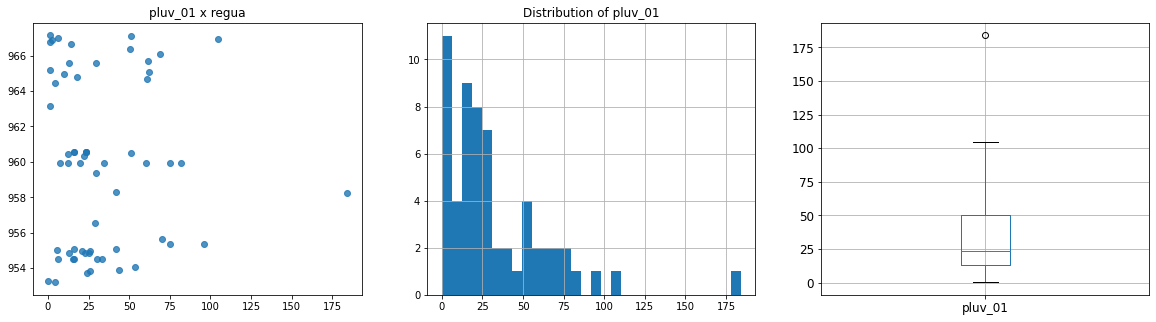

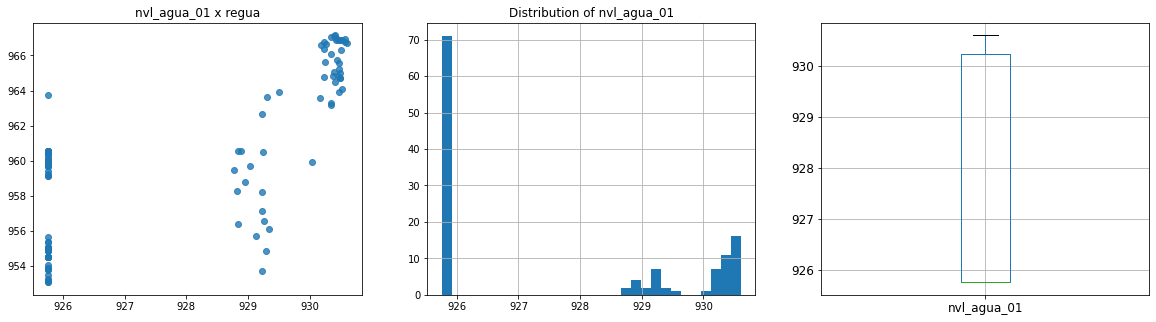

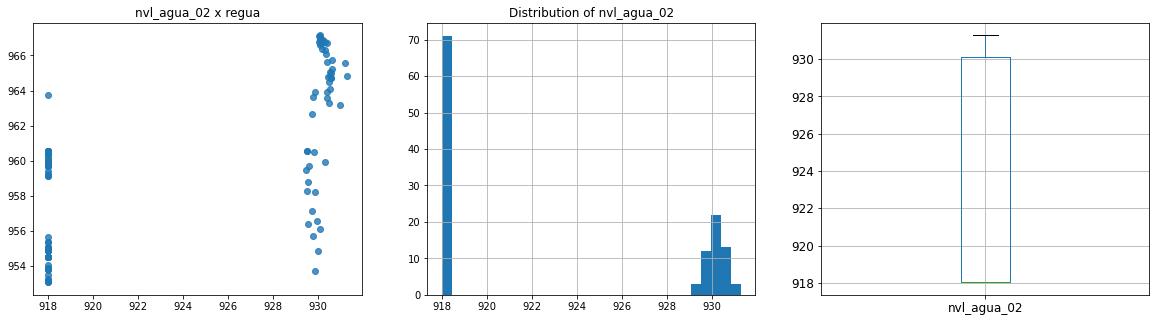

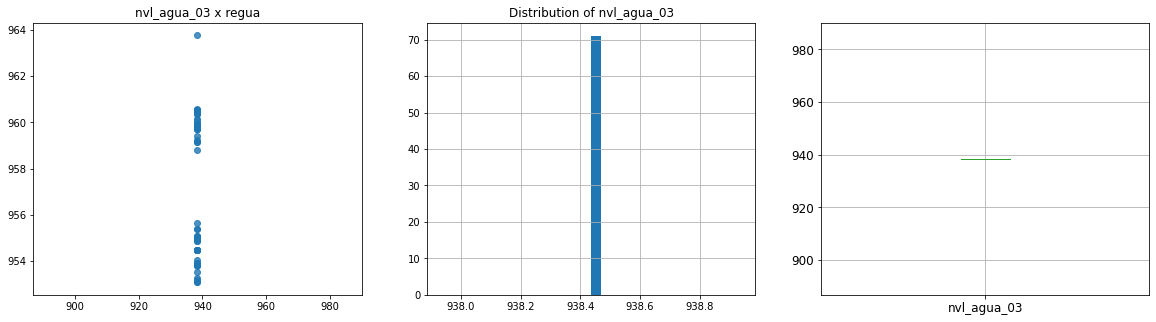

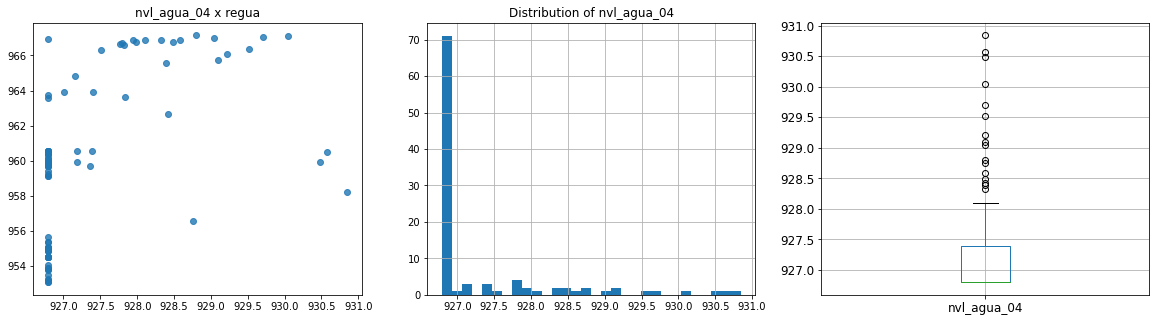

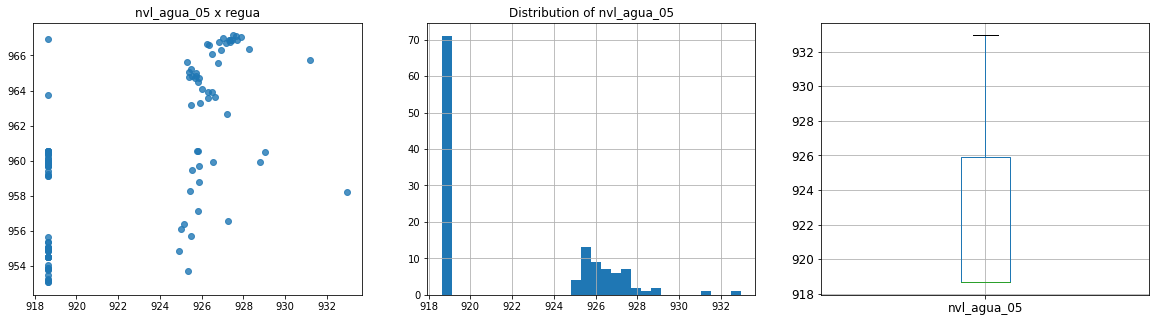

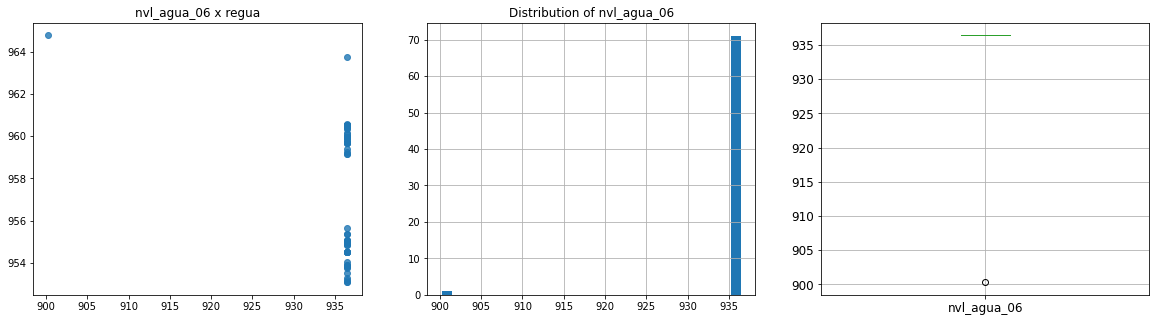

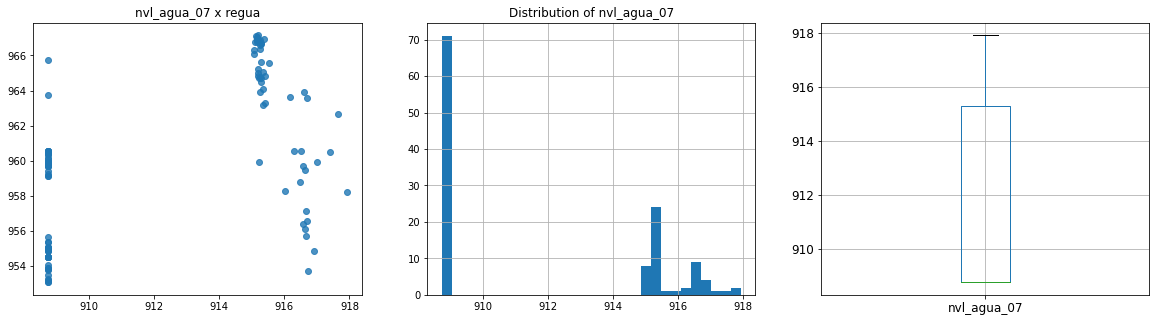

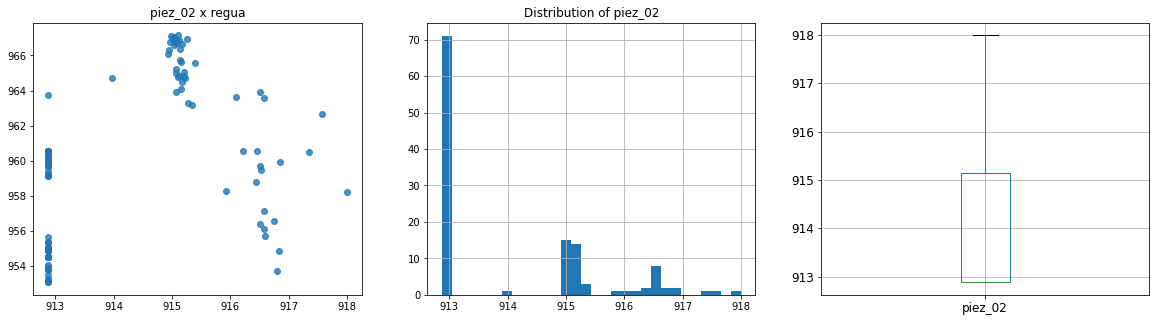

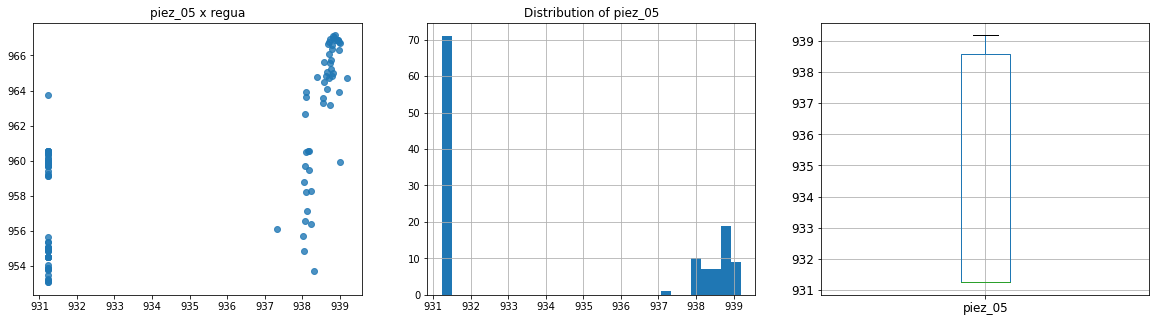

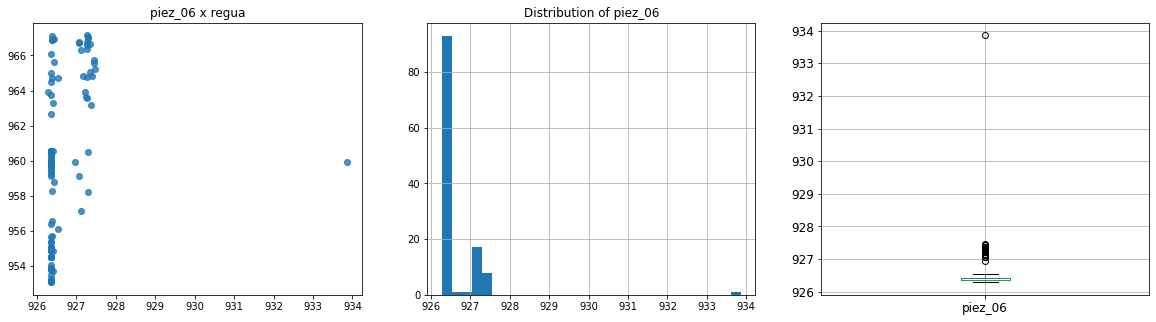

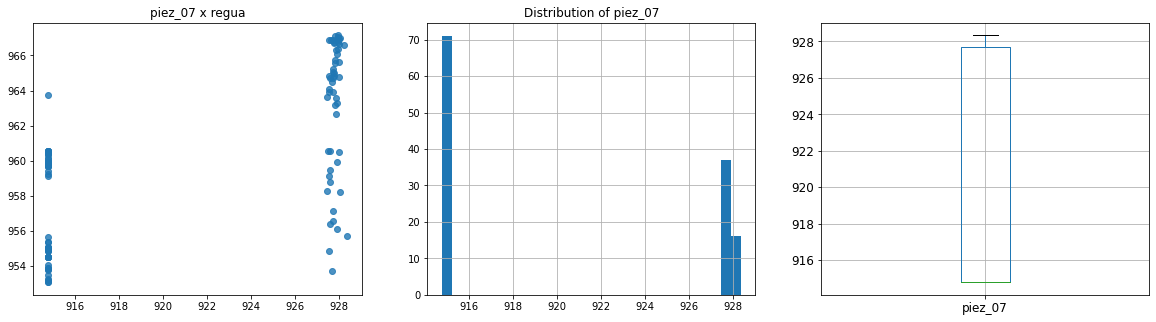

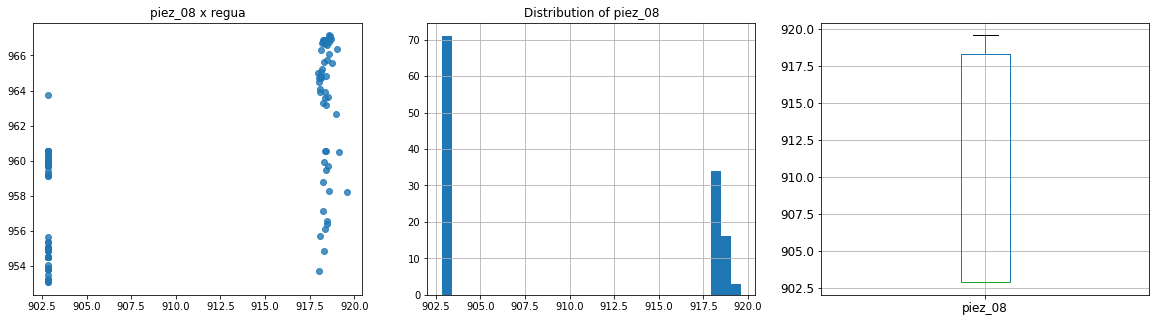

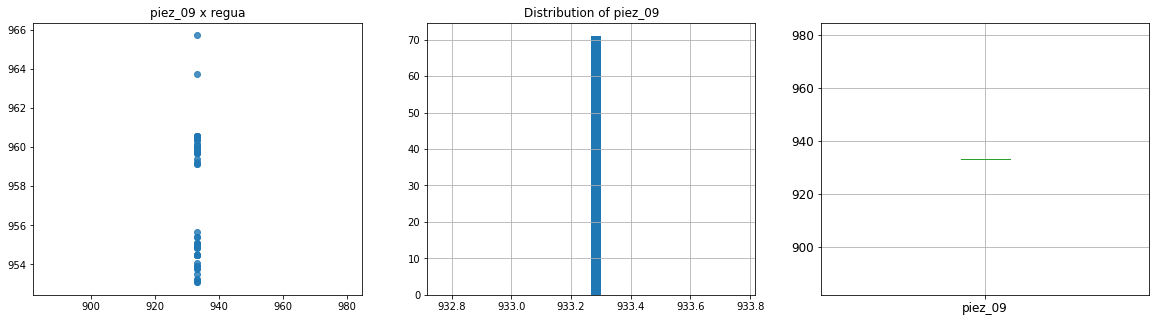

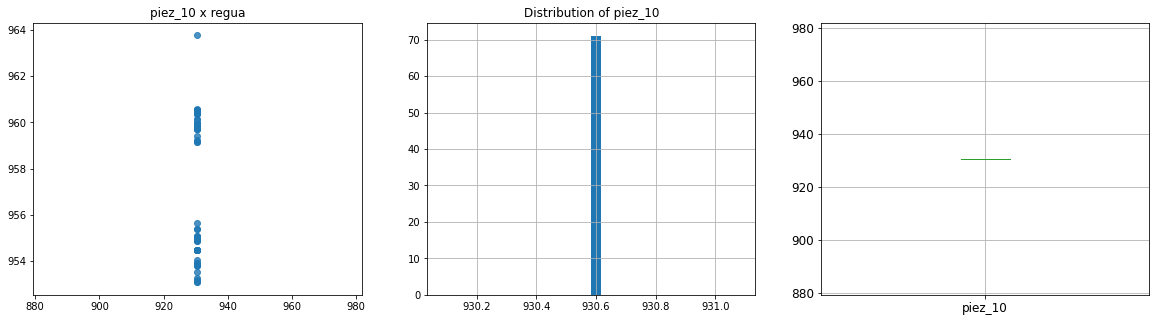

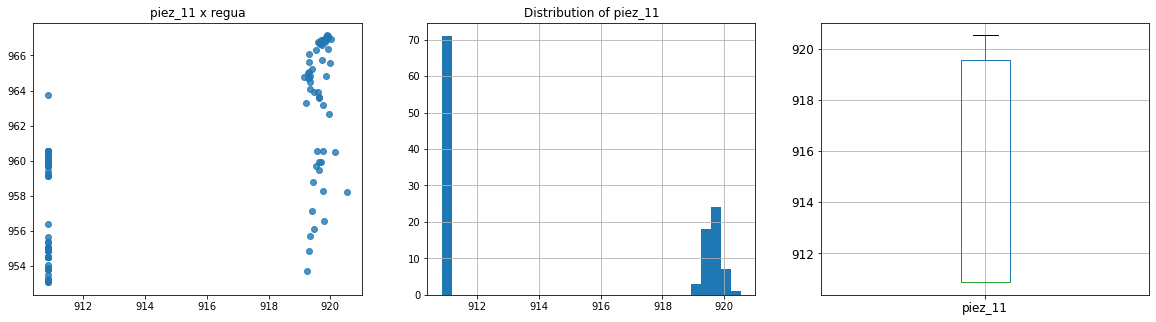

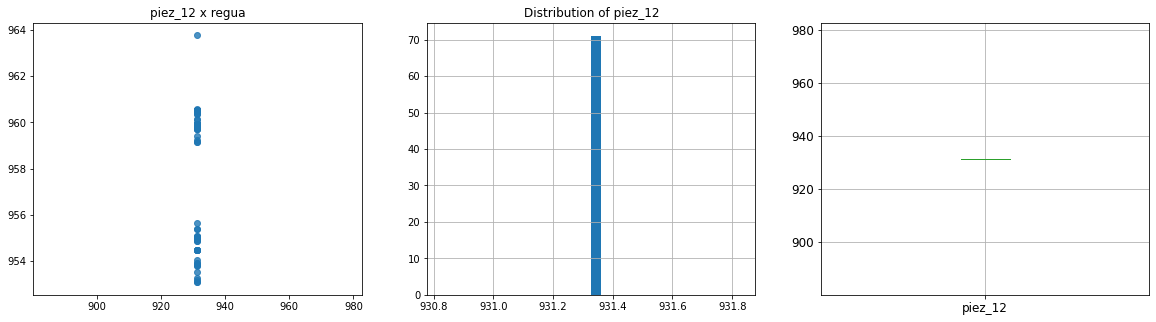

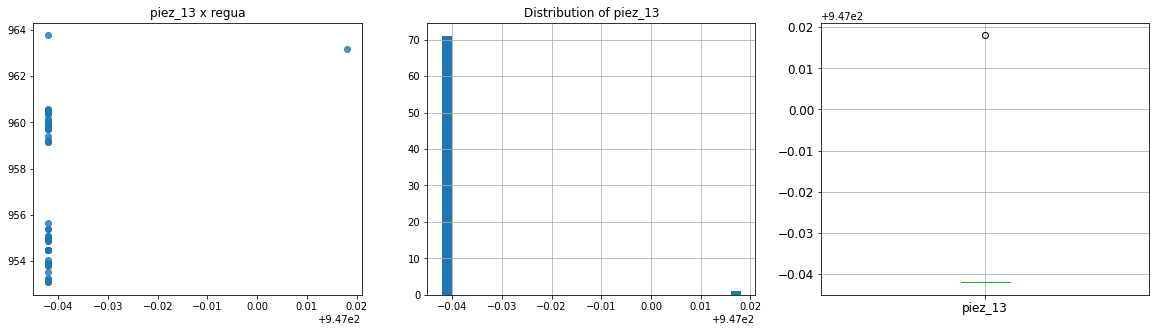

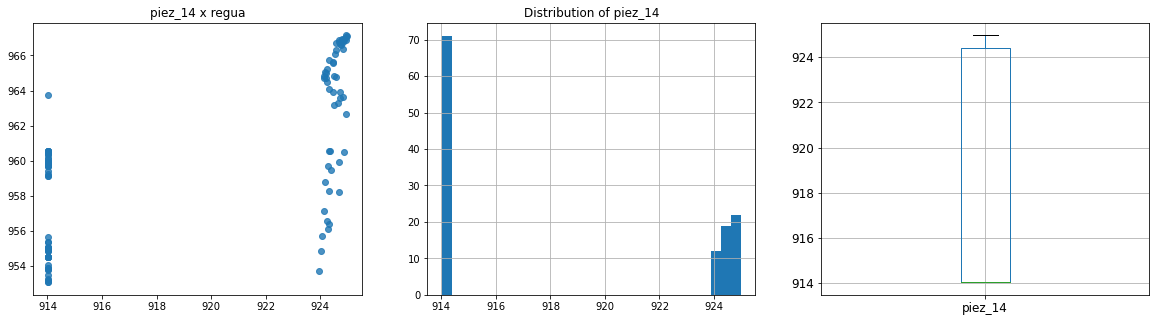

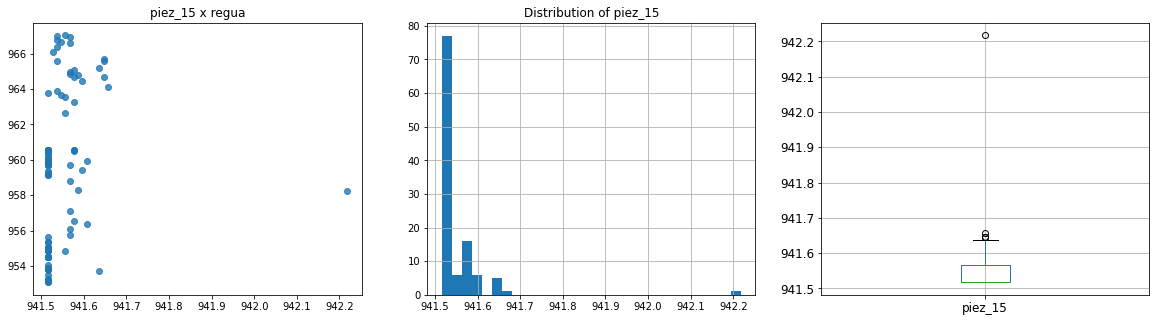

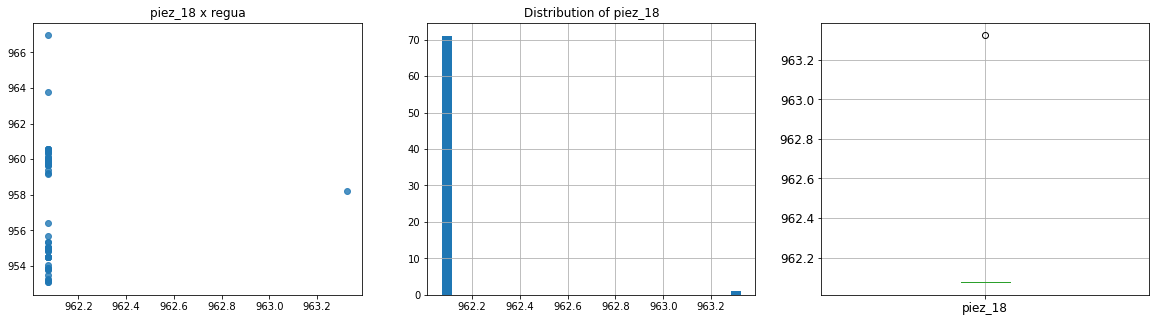

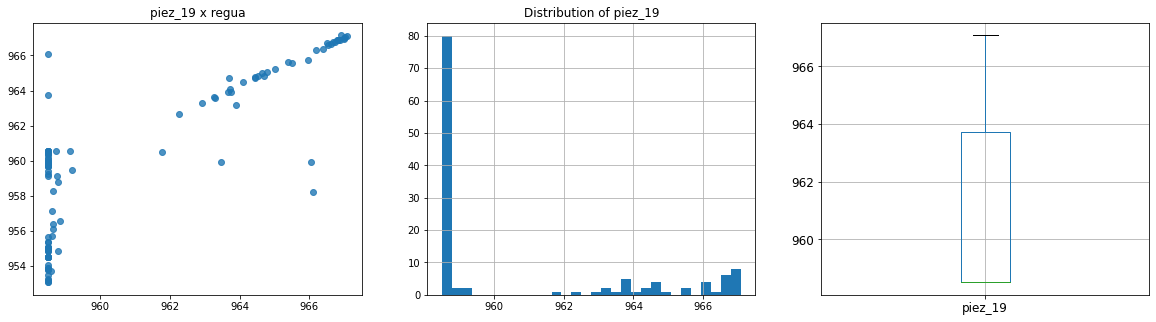

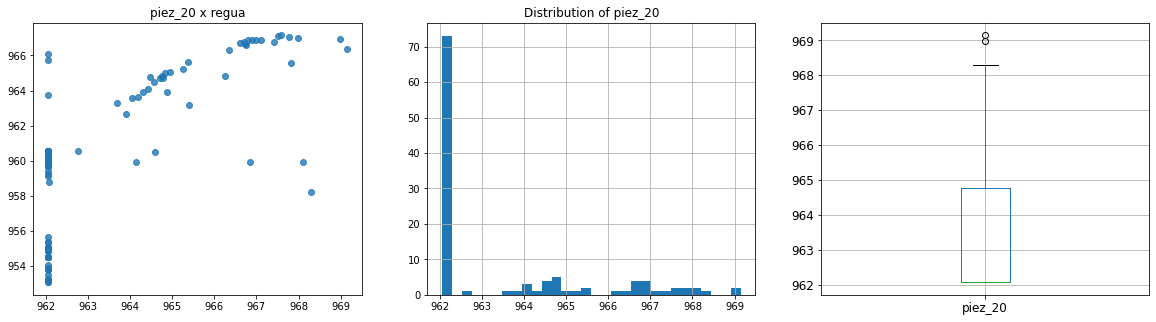

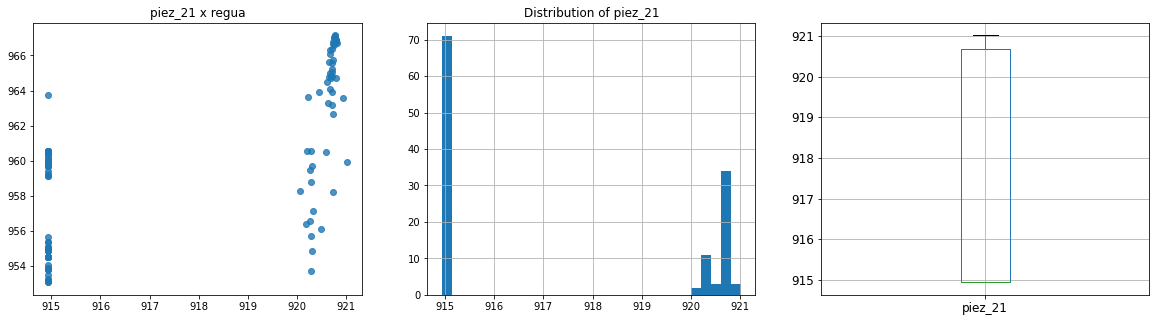

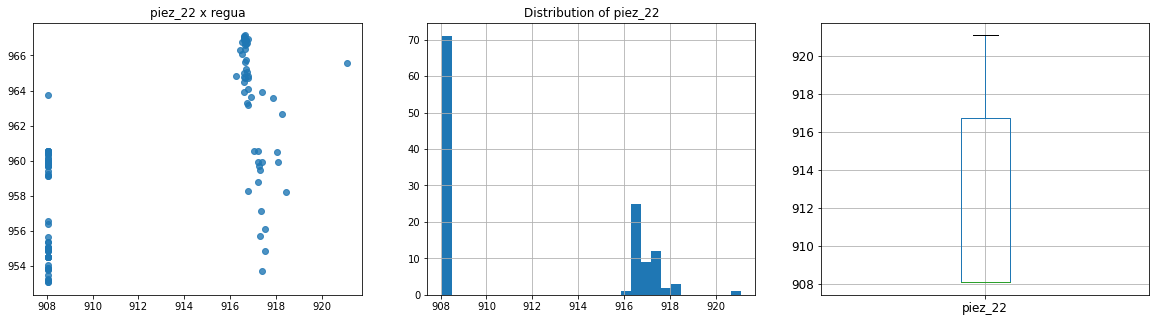

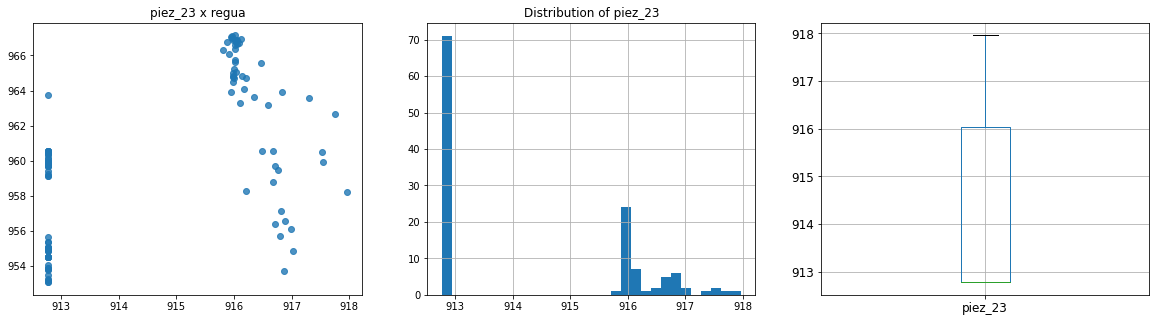

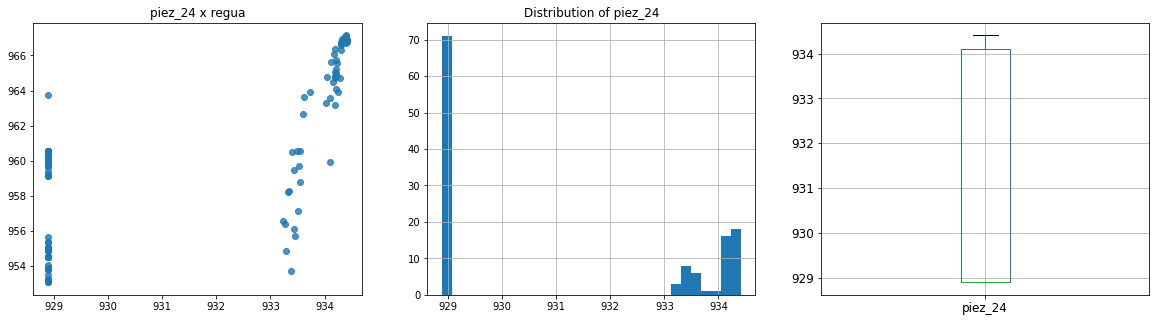

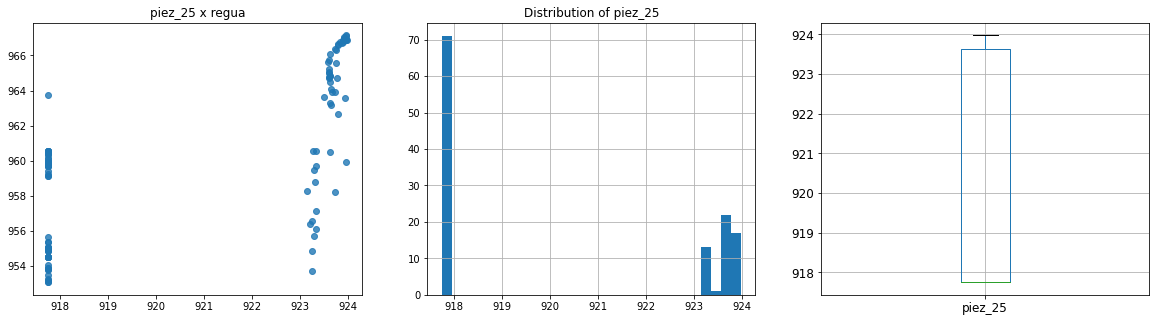

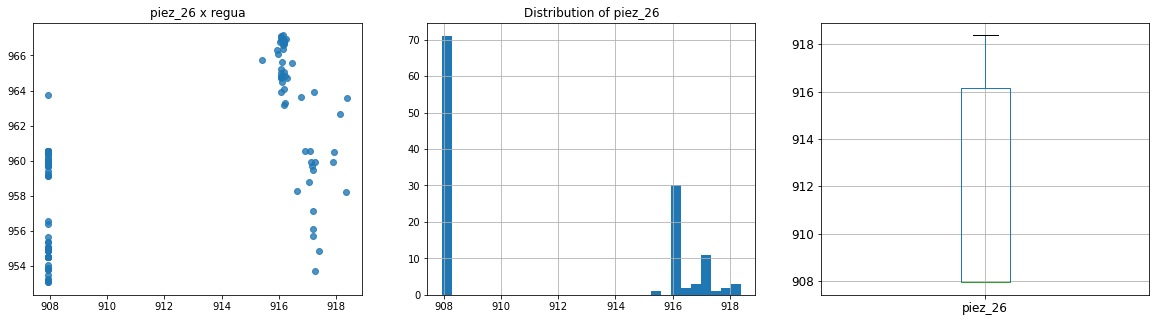

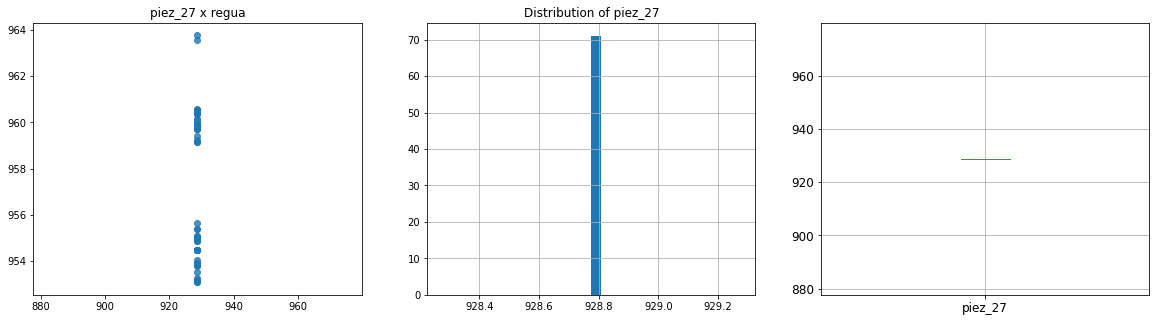

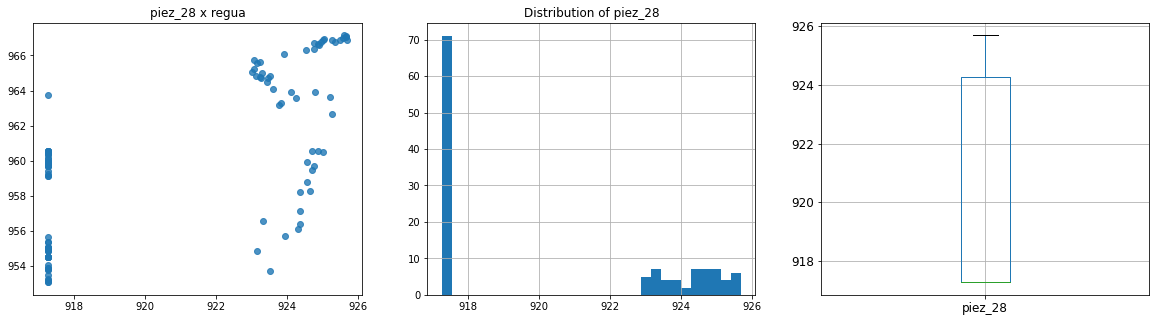

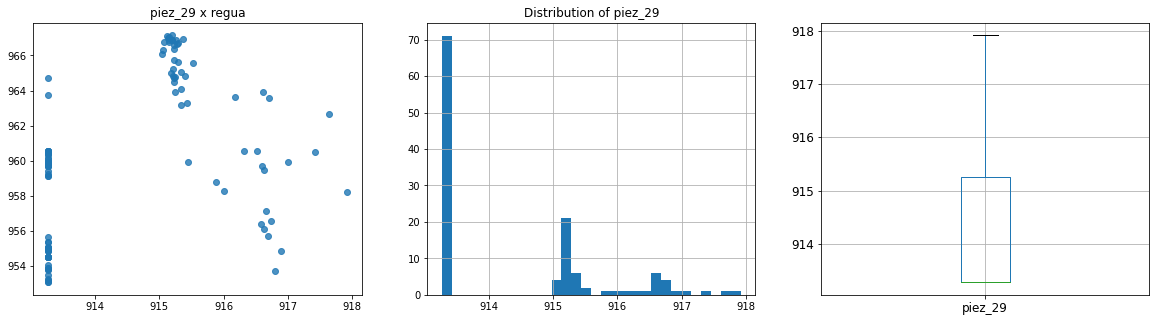

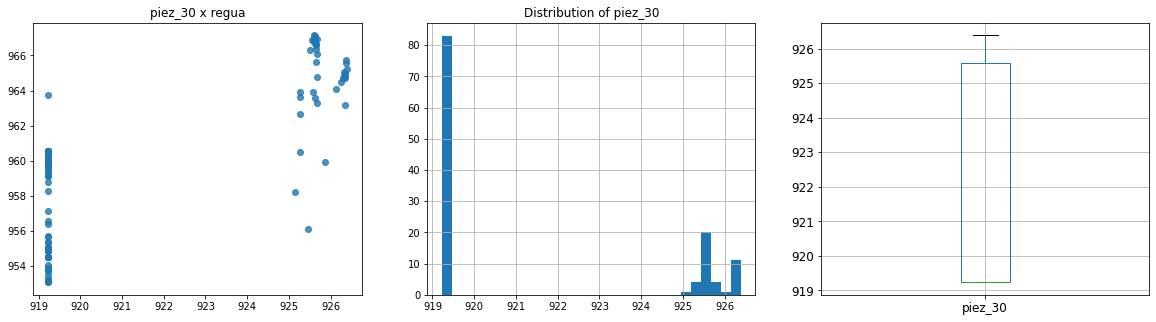

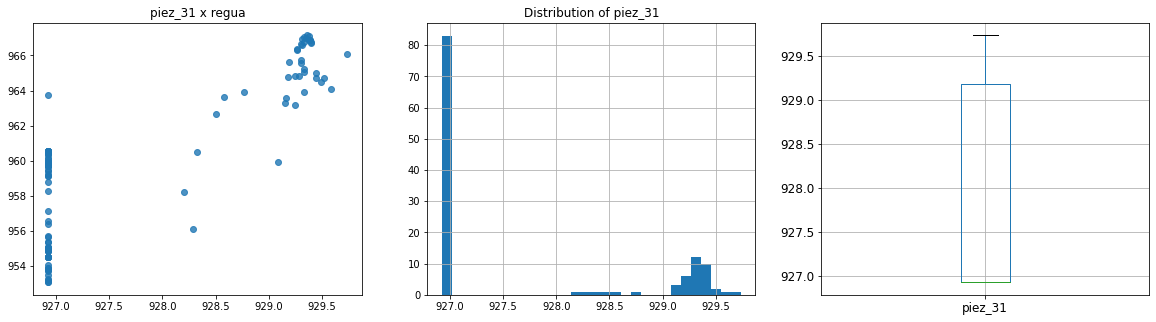

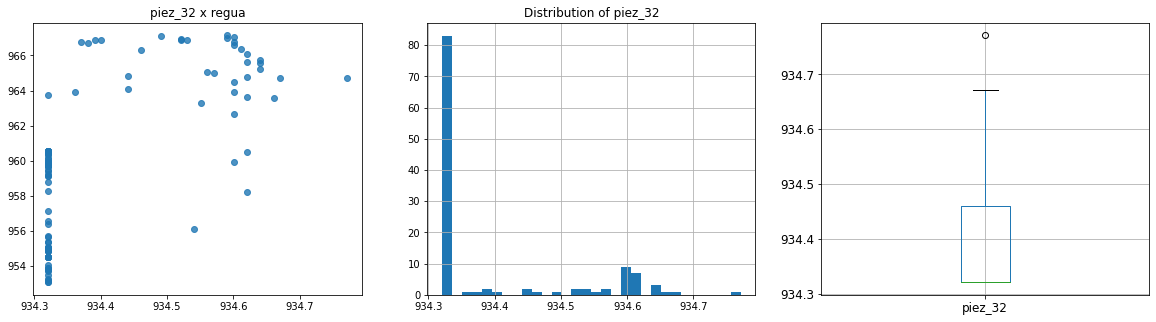

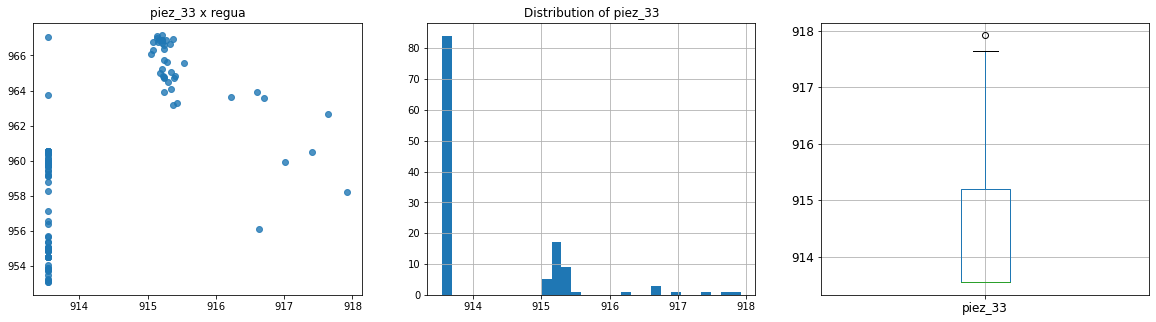

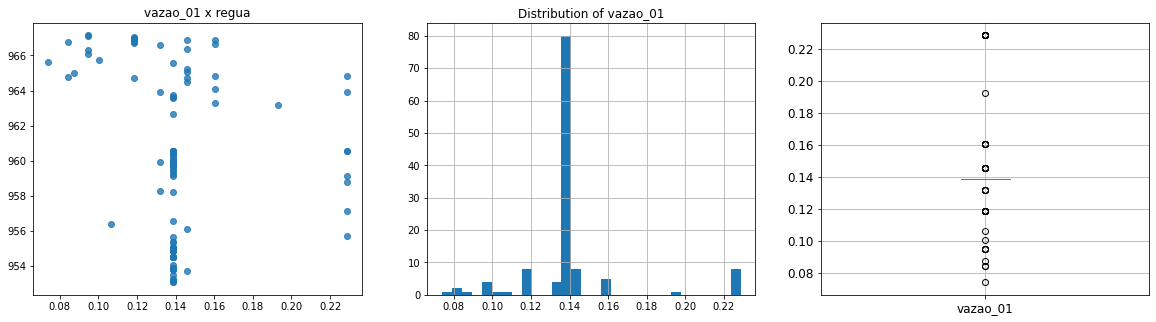

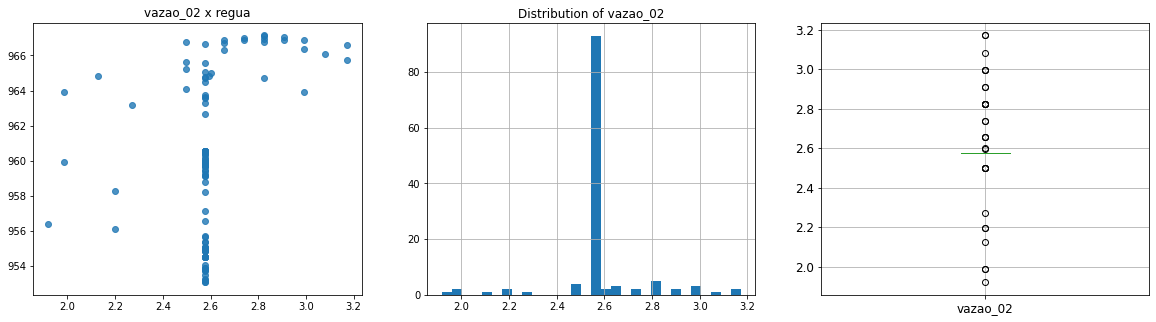

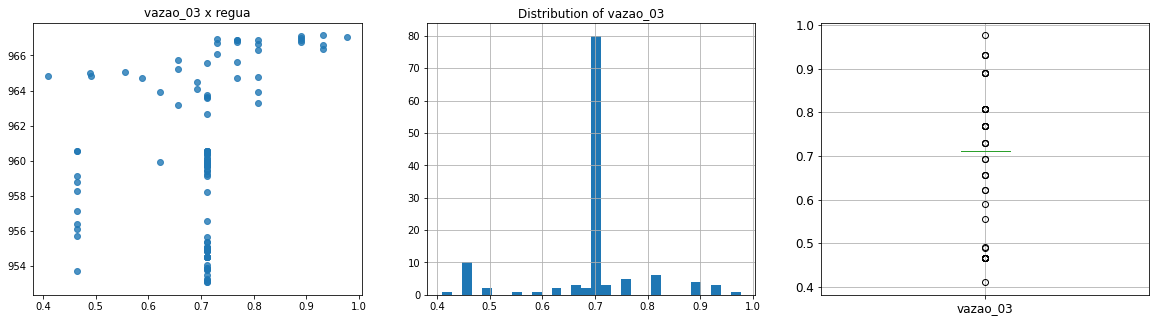

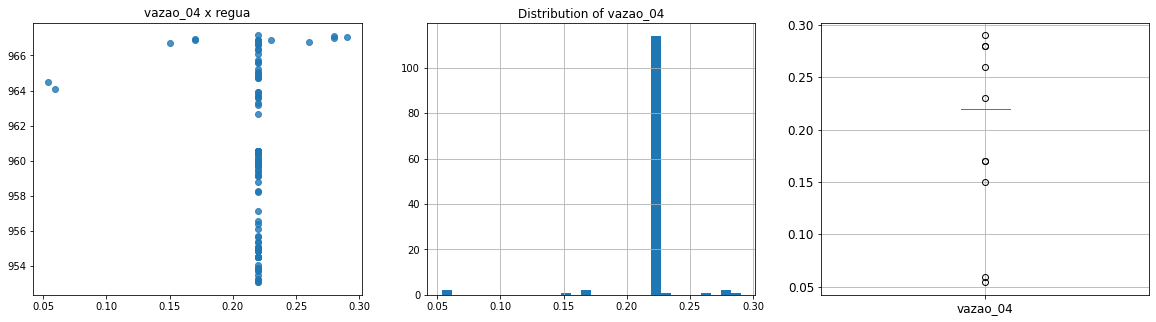

In [50]:
# Apresenta gráficos de cada variável
for i in df.columns[1:].values:
    col[1] = i
    df1 = df[col]
    
    # remove registros com 0
    df1 = df1.loc[(df1['regua'] != 0) & (df1[i] != 0)]
    
    # cria espaço para 3 gráficos em cada linha 
    f, axes = plt.subplots(nrows=1, ncols=3)
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    # Gráfico 1 - Scatter plot comparando variável com target 
    axes[0].scatter(x = df1[i], y = df1['regua'], alpha=0.8)
    axes[0].set_title(i + ' x regua')

    # Gráfico 2 - Histograma 
    df1[i].hist(bins = 30, ax = axes[1])
    axes[1].set_title('Distribution of '+ i, fontsize=12)
    
    # Gráfico 3 - Boxplot 
    df1.boxplot(column = i, ax = axes[2],fontsize=12)
    
    plt.show()

### Removendo outliers de cada variável e validando correlações individuais

In [51]:
df.drop(df[(df['regua']< 960) & (df['pluv_01']> 65)].index, inplace=True)
df.drop(df[(df['regua'] < 962) & (df['nvl_agua_04'] > 928.5)].index, inplace=True)
df.drop(df[(df['regua'] < 966) & (df['nvl_agua_05'] > 928.1)].index, inplace=True)
df.drop(df[(df['regua'] < 962) & (df['piez_06'] > 926.8)].index, inplace=True)

In [52]:
df.drop(df[(df['regua']< 958) & (df['piez_15']> 941.54)].index, inplace=True)
df.drop(df[(df['regua'] < 962) & (df['piez_20'] > 966)].index, inplace=True)
df.drop(df[(df['regua'] > 960) & (df['piez_29'] > 917.5)].index, inplace=True)

In [53]:
# Calcula e registra valores de correlação individual de cada variável com Régua do Reservatorio
# após a operação de removção de outliers
cols = df.columns[1:]

var1 = 'regua'
for col in cols:
    df2 = df[[var1, col]]
    corr = df2.corr()
    df_corr.loc[col, 'correl_depois'] = corr['regua'][1]

In [54]:
# ordena dataframe pelo valor de corr_individual
df_corr.sort_values(by=['correl_depois'], ascending=False, inplace=True)

In [55]:
df_corr

,correl_antes,correl_depois
instrumento,,
regua,1.000,1.000
piez_31,0.819,0.834
piez_19,0.805,0.829
piez_30,0.789,0.827
nvl_agua_01,0.727,0.823
piez_24,0.697,0.808
piez_25,0.671,0.799
piez_05,0.675,0.799
piez_21,0.668,0.798


In [56]:
# ========================================
# Gravando arquivo de referencia
df_corr.to_csv('df_corr_sem_out.csv', sep=';', encoding='utf-8', decimal=',')

# FASE 3 - Gráficos e listas

## Etapa 3.1 - Gráfico e lista para correlação com regua

In [57]:
xref = 0.74
df2 = df_corr.loc[df_corr['correl_depois'] >= xref]
xlim = df_corr.index.get_loc(df2.iloc[-1].name)

In [58]:
# Apresenta lista de instrumentos com alta correlação com regua
lista = list(df2.index.values)[1:]            # remove regua da lista
print('Instrumentos com correlaçao com regua maior ou igual a {0}:'.format(str(xref)))
lista

Instrumentos com correlaçao com regua maior ou igual a 0.74:


['piez_31',
 'piez_19',
 'piez_30',
 'nvl_agua_01',
 'piez_24',
 'piez_25',
 'piez_05',
 'piez_21',
 'piez_07',
 'nvl_agua_02',
 'piez_14',
 'piez_08',
 'piez_28',
 'piez_11',
 'nvl_agua_05',
 'piez_22',
 'piez_33',
 'nvl_agua_07',
 'piez_26',
 'piez_23']

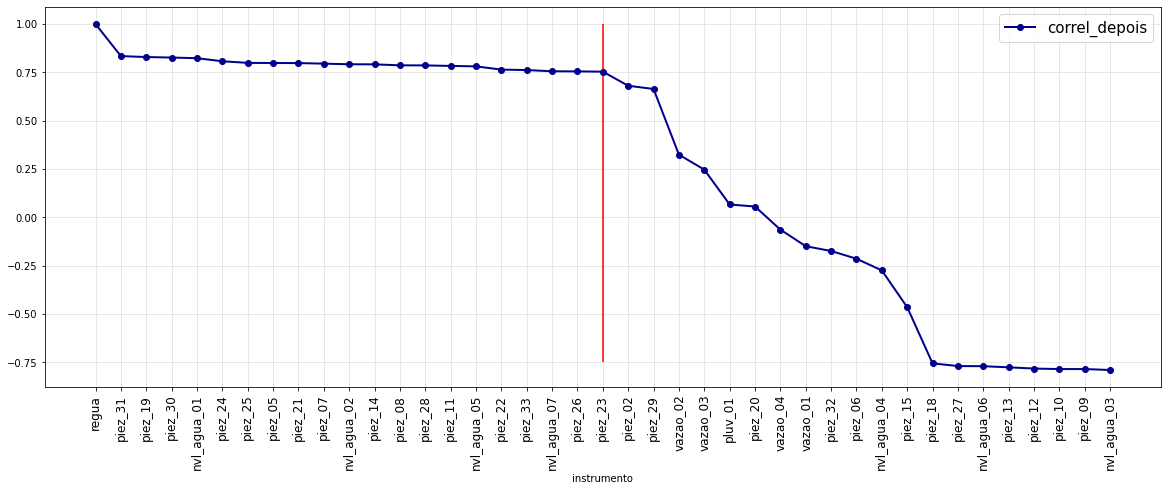

In [60]:
ax = plt.gca()
plt.rcParams['figure.figsize'] = [20, 7]

df_corr.plot(kind='line',y='correl_depois', color='darkblue', ax=ax, marker='o', linewidth=2)

ax.set_xticks(np.arange(len(df_corr)))
ax.set_xticklabels(df_corr.index, size=12)
plt.xticks(rotation=90)
plt.legend(fontsize=15, loc=1)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.vlines(xlim, ymin=-0.75, ymax=1, color='red')
plt.show()


## Etapa 3.2 - Comportamento dos instrumentos com maior correlaçao com regua

**Gráficos boxplot da regua, pluviometro e instrumentos com maior correlação com a régua com medidas agrupadas por meses**

In [61]:
df = pd.read_csv('df_set.csv', sep=';', encoding='latin1', decimal=',', parse_dates=['data_med'])

In [62]:
lista = list(df2.index.values)
df_plu.reset_index(inplace=True)
#lista.insert(1,'pluviometro')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


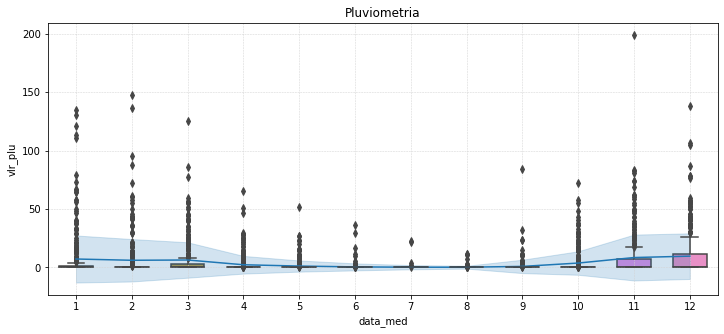

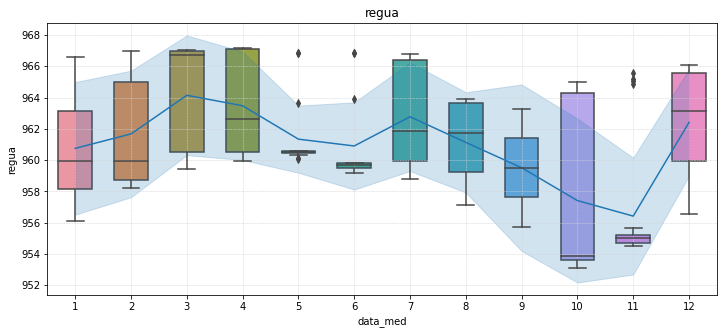

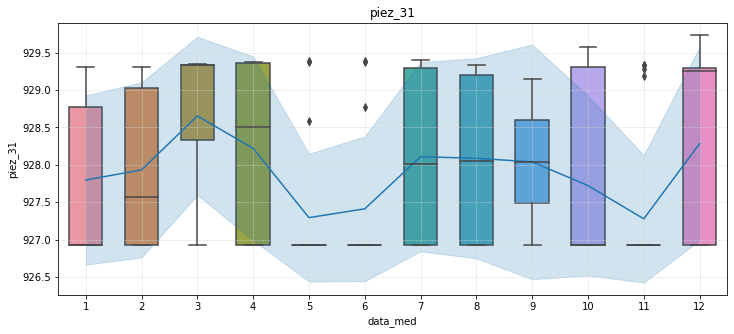

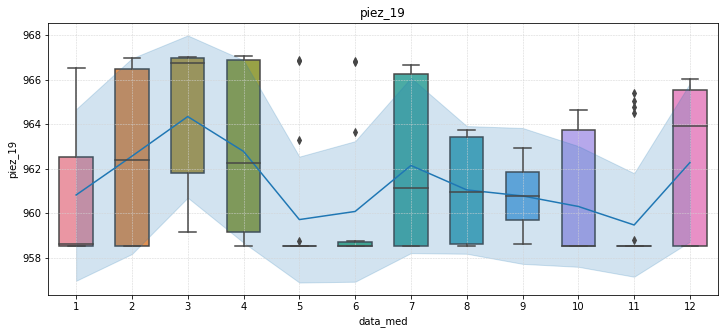

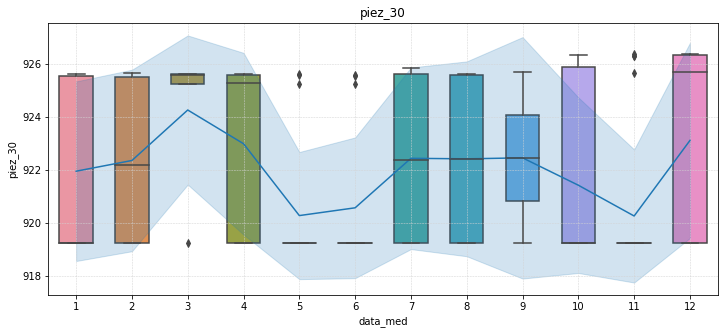

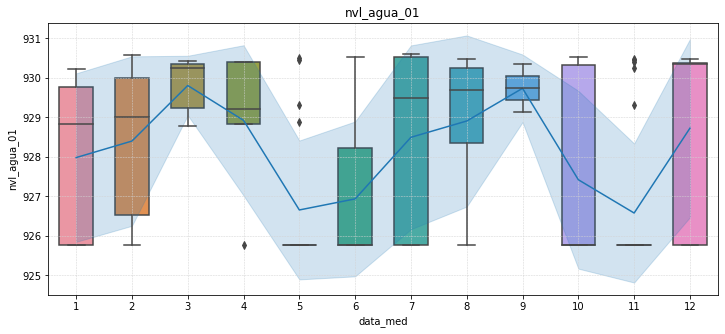

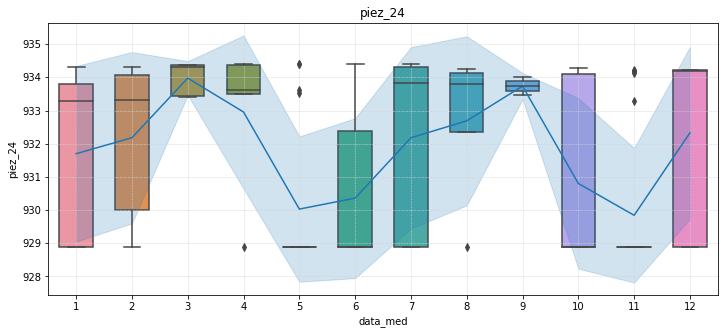

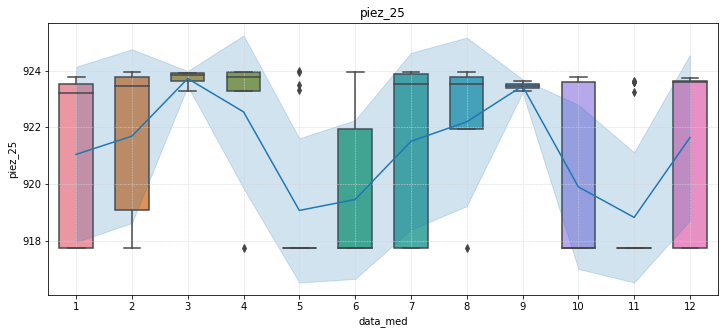

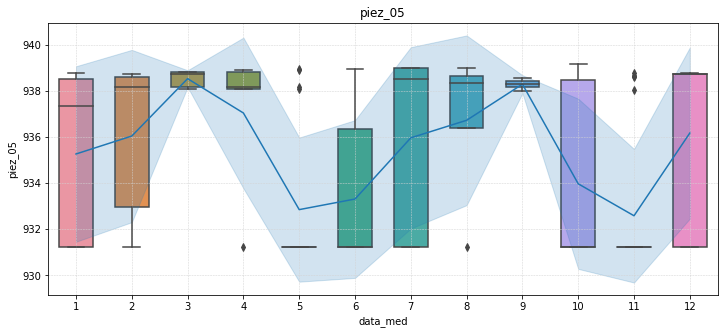

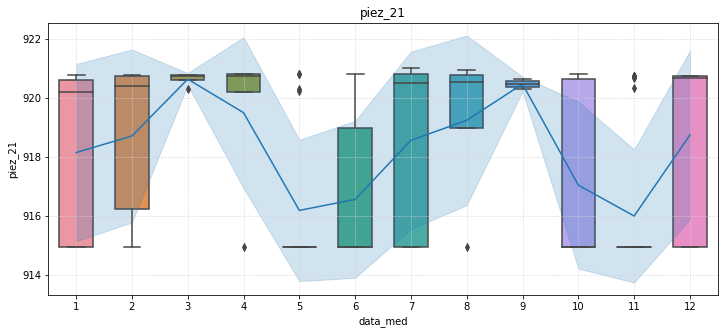

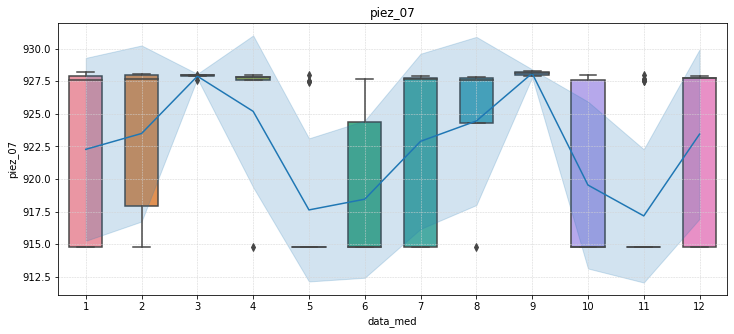

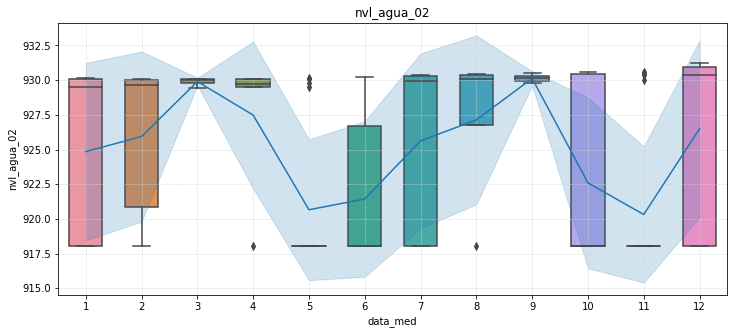

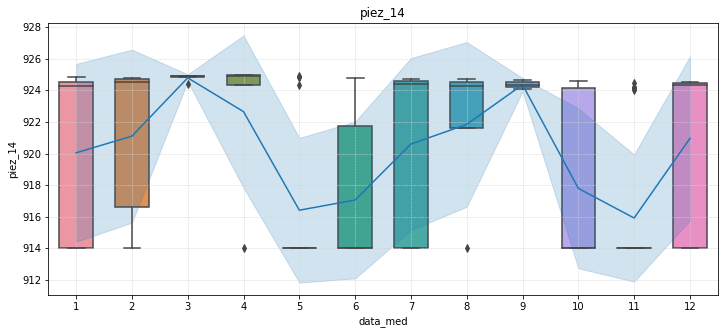

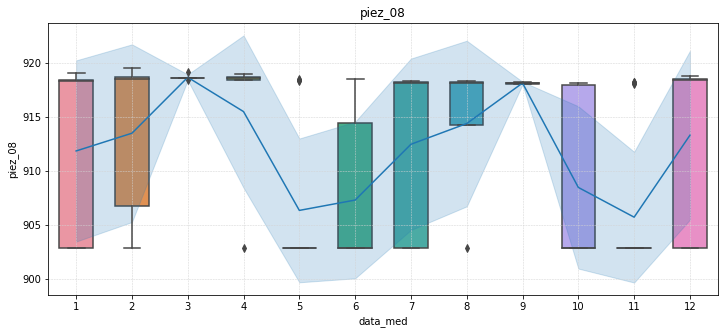

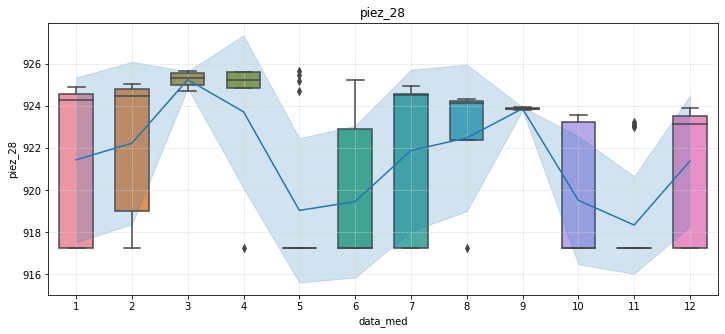

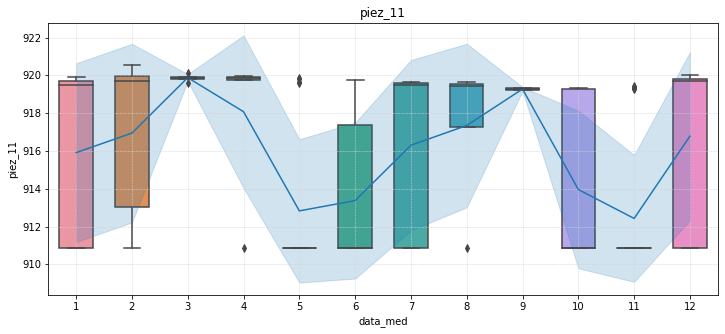

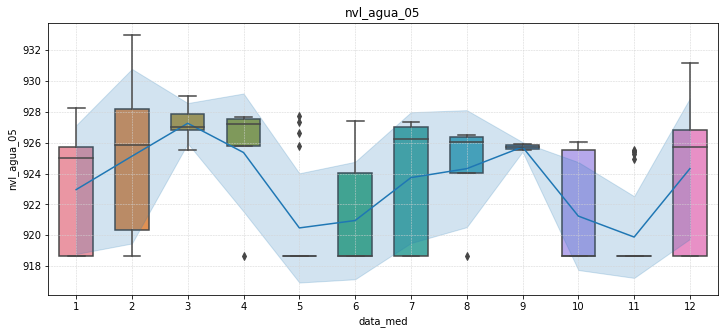

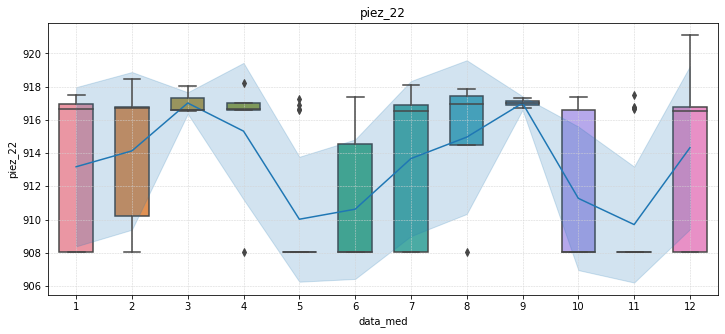

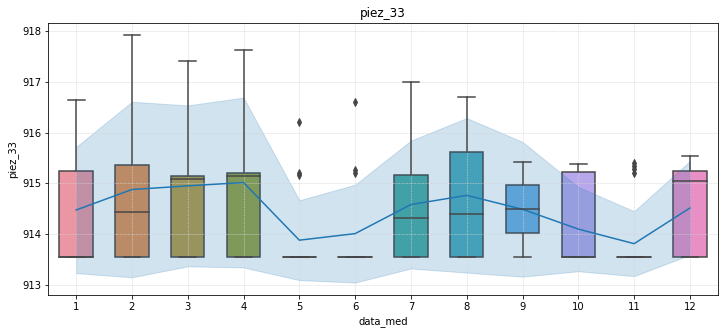

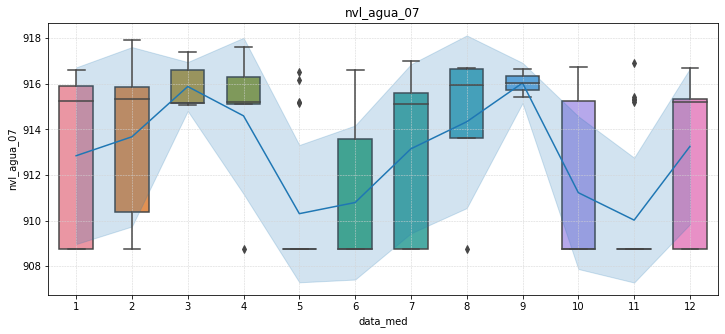

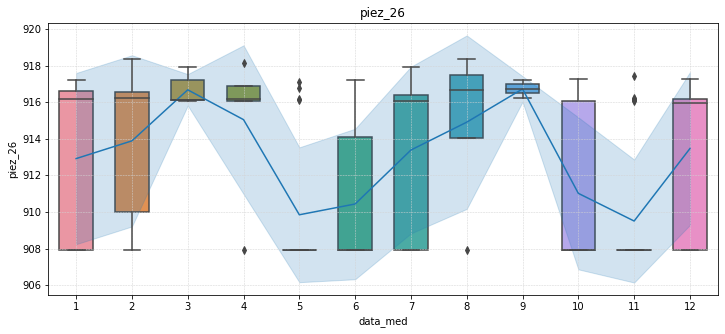

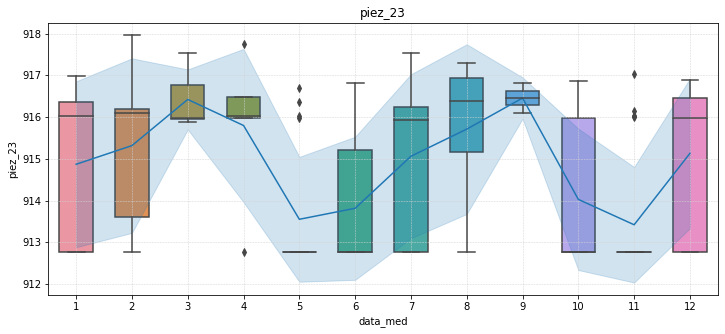

In [63]:
# Grafico de comportamento da regua
plt.rcParams['figure.figsize'] = [12, 5]
sns.boxplot(x=df_plu['data_med'].dt.month, y=df_plu['vlr_plu'], width=0.6)
sns.lineplot(x=df_plu['data_med'].dt.month-1, y=df_plu['vlr_plu'], markers=True, estimator='mean', ci='sd');
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.title('Pluviometria')
plt.show

for inst in lista:
    f, axes = plt.subplots(nrows=1, ncols=1)
    plt.rcParams['figure.figsize'] = [12, 5]
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    sns.boxplot(x=df['data_med'].dt.month, y=df[inst], width=0.6)
    sns.lineplot(x=df['data_med'].dt.month-1, y=df[inst], markers=True, estimator='mean', ci='sd');
    plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
    plt.title(inst)
    
    plt.show